In [58]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
debug_mode = True

# load data

In [3]:
if debug_mode == True:
    train = pd.read_feather('../data/train_data.feather').sample(500000*3)
if debug_mode == False:
    train = pd.read_feather('../data/train_data.feather')
test = pd.read_feather('../data/test_data.feather')
print(train.shape,test.shape)
df = train.append(test).reset_index(drop=True)
print(df.shape)
display(df)

(1500000, 54) (500000, 54)
(2000000, 54)


,index,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,26684022,21.0,10337883.0,13,1.0,2483.551527,0.0,1.0,0.0,0.0,...,2.0,3.0,2.0,1.0,6.0,30.0,59701.507360,1.0,3.0,1.0
1,31406377,24.0,10373225.0,22,1.0,10564.539532,1.0,0.0,0.0,0.0,...,1.0,2.0,11.0,1.0,2.0,30.0,97471.116631,0.0,4.0,1.0
2,10287624,9.0,10464102.0,34,1.0,5835.016855,1.0,0.0,0.0,0.0,...,1.0,3.0,11.0,1.0,2.0,30.0,135980.075533,0.0,5.0,1.0
3,6177417,6.0,10400042.0,6,1.0,9440.012471,1.0,0.0,0.0,0.0,...,1.0,5.0,15.0,1.0,3.0,30.0,62730.806297,0.0,4.0,1.0
4,3476541,4.0,10211412.0,45,3.0,4953.135169,3.0,0.0,0.0,0.0,...,1.0,6.0,6.0,1.0,99.0,30.0,68561.179121,1.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,499995,1.0,10306817.0,10,1.0,8038.265093,0.0,1.0,0.0,0.0,...,1.0,2.0,8.0,1.0,2.0,30.0,95982.822967,0.0,4.0,1.0
1999996,499996,1.0,10483487.0,41,1.0,10567.025245,0.0,1.0,0.0,0.0,...,1.0,5.0,11.0,1.0,2.0,30.0,82203.126286,1.0,4.0,1.0
1999997,499997,1.0,10218632.0,33,1.0,6308.563642,1.0,0.0,0.0,0.0,...,2.0,3.0,11.0,1.0,2.0,30.0,71382.709400,0.0,4.0,1.0
1999998,499998,1.0,10146871.0,48,1.0,5773.036485,1.0,0.0,0.0,0.0,...,2.0,3.0,11.0,1.0,2.0,30.0,68561.179121,0.0,3.0,1.0


# check miss value

In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
miss_table = missing_values_table(df)
miss_table

Your selected dataframe has 54 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
slam,108403,5.4
gender_code,26251,1.3
age,26251,1.3
trdtp,21,0.0


# handle miss value

In [5]:
df.dropna(axis=1,inplace=True)
miss_table = missing_values_table(df)
miss_table

Your selected dataframe has 50 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


# 特徵工程
groupby chid 然後去計算對於 shop_tag 的 nunique,norm_count

In [6]:
def agg_function(df,group_var,features):
    agg = df[features+[group_var]].groupby(group_var).agg(["nunique"]).reset_index()
    columns = [group_var]
    for var in agg.columns.levels[0]:
      if var != group_var:
        for stat in agg.columns.levels[1][:-1]:
          columns.append('%s_%s_%s' % (group_var,var,stat))
    agg.columns = columns
    return agg

def count_categorical(df, group_var,categorical_features):
    categorical = pd.get_dummies(df[categorical_features],columns=categorical_features)
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
      for stat in ['norm_count']:
        column_names.append('%s_%s_%s' % (group_var, var, stat))
    categorical.columns = column_names
    return categorical

In [7]:
print(df.shape)
df = df.merge(agg_function(df,'chid',['shop_tag']),on='chid',how='left')
print(df.shape)
df = df.merge(count_categorical(df,'chid',['shop_tag']),on='chid',how='left')
print(df.shape)

(2000000, 50)
(2000000, 51)
(2000000, 100)


# 拆回train and test

In [8]:
train = df.iloc[:-500000]
test = df.iloc[-500000:]
print(train.shape,test.shape)

(1500000, 100) (500000, 100)


# 篩選特徵

In [23]:
train.columns

Index(['index', 'dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt',
       'domestic_offline_cnt', 'domestic_online_cnt', 'overseas_offline_cnt',
       'overseas_online_cnt', 'domestic_offline_amt_pct',
       'domestic_online_amt_pct', 'overseas_offline_amt_pct',
       'overseas_online_amt_pct', 'card_1_txn_cnt', 'card_2_txn_cnt',
       'card_3_txn_cnt', 'card_4_txn_cnt', 'card_5_txn_cnt', 'card_6_txn_cnt',
       'card_7_txn_cnt', 'card_8_txn_cnt', 'card_9_txn_cnt', 'card_10_txn_cnt',
       'card_11_txn_cnt', 'card_12_txn_cnt', 'card_13_txn_cnt',
       'card_14_txn_cnt', 'card_other_txn_cnt', 'card_1_txn_amt_pct',
       'card_2_txn_amt_pct', 'card_3_txn_amt_pct', 'card_4_txn_amt_pct',
       'card_5_txn_amt_pct', 'card_6_txn_amt_pct', 'card_7_txn_amt_pct',
       'card_8_txn_amt_pct', 'card_9_txn_amt_pct', 'card_10_txn_amt_pct',
       'card_11_txn_amt_pct', 'card_12_txn_amt_pct', 'card_13_txn_amt_pct',
       'card_14_txn_amt_pct', 'card_other_txn_amt_pct', 'masts', 'educd',
     

In [49]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRFClassifier

v = train.sample(10000) # 減少計算時間
X = v.drop(['index','shop_tag'],axis=1) # 去除索引和y
y = v['shop_tag']
selector = SelectFromModel(estimator=XGBRFClassifier(objective='multi:softmax')).fit(X, y) # 多分類任務
# 計算特徵score
res = pd.DataFrame(dict(zip(X.columns,selector.estimator_.feature_importances_)),index=[*range(len(X.columns))]).T[[0]]
res.columns = ['score']
res = res.sort_values(by='score',ascending=False)
res.head(20)

C:\Users\ricky\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,score
chid_shop_tag_37_norm_count,0.052406
chid_shop_tag_other_norm_count,0.037901
chid_shop_tag_45_norm_count,0.037514
chid_shop_tag_48_norm_count,0.032610
card_4_txn_cnt,0.030961
overseas_online_cnt,0.029766
chid_shop_tag_36_norm_count,0.028707
chid_shop_tag_2_norm_count,0.028011
chid_shop_tag_15_norm_count,0.027839
chid_shop_tag_12_norm_count,0.027561


# 

In [50]:
# 篩選前k名特徵
k = 42
k_feats = res.head(k).index.tolist()
train = train[k_feats+['index']+['shop_tag']]
test = test[k_feats+['index']]
print(train.shape,test.shape)

(1500000, 44) (500000, 43)


# 處裡共線性問題

In [51]:
corrs = abs(train.corr())
threshold = 0.8
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [52]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []
for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  1


In [53]:
train = train.drop(cols_to_remove,axis=1)
test = test.drop(cols_to_remove,axis=1)

<AxesSubplot:>

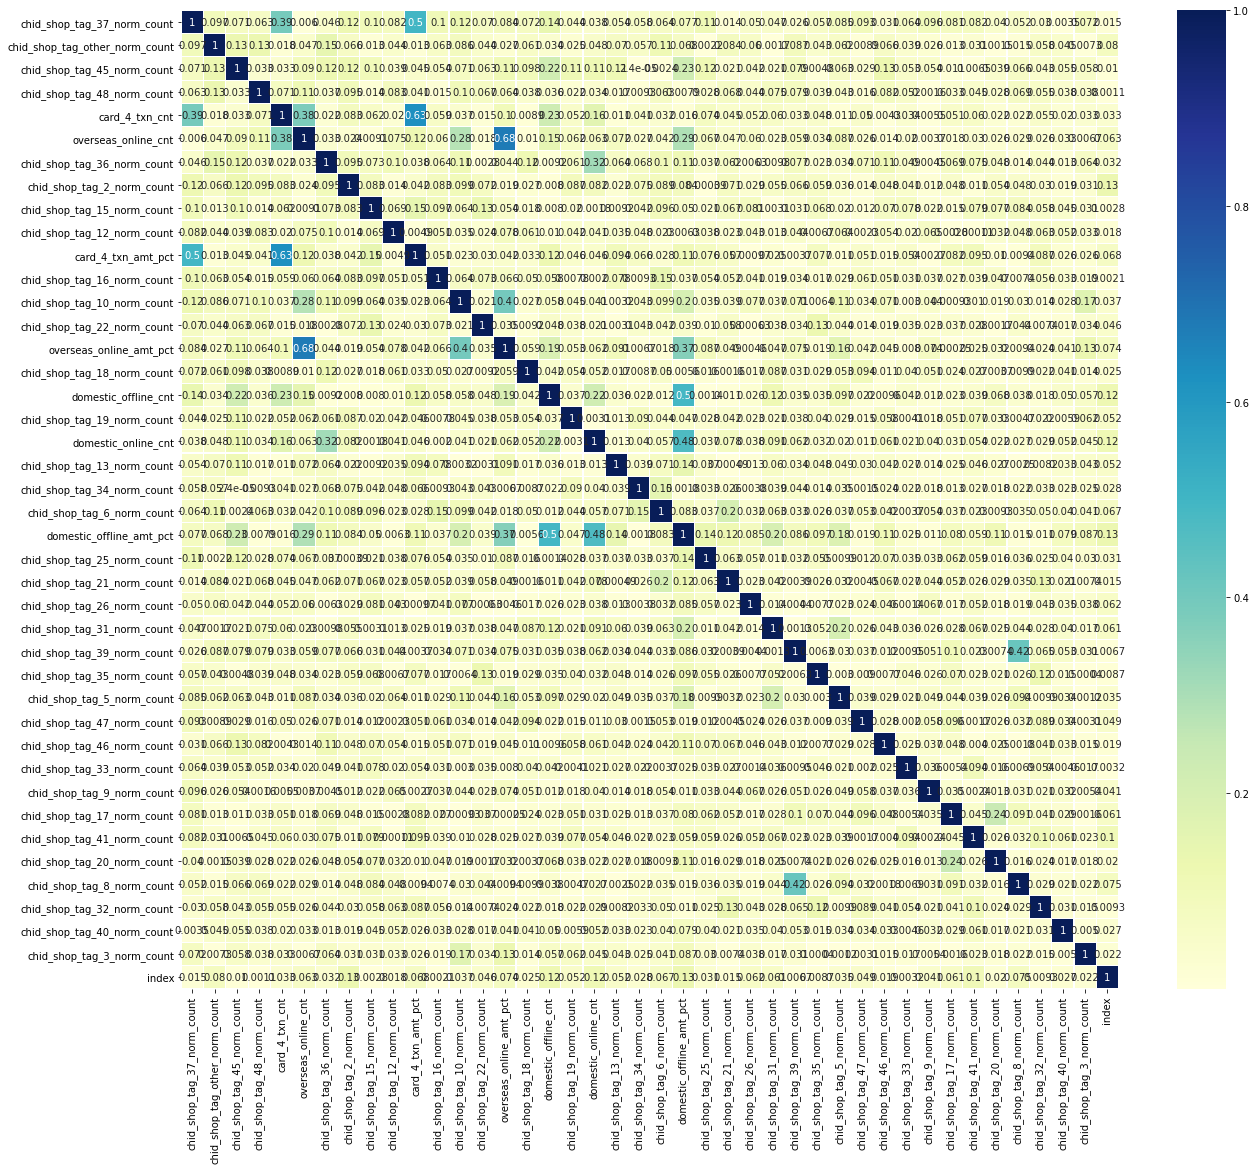

In [59]:
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(train.sample(333).corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

# final check data

In [63]:
train = train.reset_index(drop=True)
print(train.shape)
print(train.isnull().sum().sum())
train.head()

(1500000, 43)
0


,chid_shop_tag_37_norm_count,chid_shop_tag_other_norm_count,chid_shop_tag_45_norm_count,chid_shop_tag_48_norm_count,card_4_txn_cnt,overseas_online_cnt,chid_shop_tag_36_norm_count,chid_shop_tag_2_norm_count,chid_shop_tag_15_norm_count,chid_shop_tag_12_norm_count,...,chid_shop_tag_9_norm_count,chid_shop_tag_17_norm_count,chid_shop_tag_41_norm_count,chid_shop_tag_20_norm_count,chid_shop_tag_8_norm_count,chid_shop_tag_32_norm_count,chid_shop_tag_40_norm_count,chid_shop_tag_3_norm_count,index,shop_tag
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26684022,13
1,0.133333,0.066667,0.000000,0.000000,0.0,0.0,0.000000,0.2,0.133333,0.000000,...,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31406377,22
2,0.000000,0.600000,0.200000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10287624,34
3,0.000000,0.500000,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6177417,6
4,0.230769,0.076923,0.153846,0.076923,3.0,0.0,0.230769,0.0,0.000000,0.076923,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3476541,45


In [64]:
test = test.reset_index(drop=True)
print(test.shape)
print(test.isnull().sum().sum())
test.head()

(500000, 42)
0


,chid_shop_tag_37_norm_count,chid_shop_tag_other_norm_count,chid_shop_tag_45_norm_count,chid_shop_tag_48_norm_count,card_4_txn_cnt,overseas_online_cnt,chid_shop_tag_36_norm_count,chid_shop_tag_2_norm_count,chid_shop_tag_15_norm_count,chid_shop_tag_12_norm_count,...,chid_shop_tag_33_norm_count,chid_shop_tag_9_norm_count,chid_shop_tag_17_norm_count,chid_shop_tag_41_norm_count,chid_shop_tag_20_norm_count,chid_shop_tag_8_norm_count,chid_shop_tag_32_norm_count,chid_shop_tag_40_norm_count,chid_shop_tag_3_norm_count,index
0,0.2500,0.25,0.2500,0.0000,3.0,0.0,0.00,0.2500,0.0000,0.0,...,0.0,0.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0
1,0.1000,0.10,0.1000,0.1000,0.0,0.0,0.05,0.0000,0.1000,0.0,...,0.0,0.0,0.0500,0.05,0.0,0.0,0.0,0.0,0.0,1
2,0.2000,0.20,0.0000,0.2000,0.0,0.0,0.20,0.0000,0.0000,0.0,...,0.0,0.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,2
3,0.0625,0.00,0.1875,0.0625,0.0,0.0,0.00,0.0625,0.0625,0.0,...,0.0,0.0,0.0625,0.00,0.0,0.0,0.0,0.0,0.0,3
4,0.2500,0.00,0.0000,0.0000,1.0,0.0,0.00,0.5000,0.0000,0.0,...,0.0,0.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,4


# save data

In [65]:
train.to_feather("../data/train_preprocessed.feather")
test.to_feather("../data/test_preprocessed.feather")
print('save done!')

save done!
